In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pywaffle import Waffle
from pypalettes import load_cmap
from pyfonts import load_google_font
from drawarrow import ax_arrow, fig_arrow
from highlight_text import fig_text

In [2]:
prizes = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-10-28/prizes.csv")

In [3]:
prizes

,prize_id,prize_alias,prize_name,prize_institution,prize_year,prize_genre,person_id,person_role,last_name,first_name,...,uk_residence,ethnicity_macro,ethnicity,highest_degree,degree_institution,degree_field_category,degree_field,viaf,book_id,book_title
0,8,Booker Prize,Booker Prize,Booker Foundation,1991,fiction,294,shortlisted,Amis,Martin,...,True,White British,English,Bachelors,University of Oxford,Language and Literature,English Literature,36913662,5,Time's Arrow
1,1,James Tait Black Prize for Fiction,James Tait Black Prize for Fiction,The University of Edinburgh,1991,fiction,33,winner,Boyd,William,...,True,White British,British,unknown,University of Oxford,Language and Literature,English Literature,111500719,36,Brazzaville Beach
2,3,Costa First Novel Award,Whitbread First Novel,Whitbread,1991,fiction,167,winner,Burn,Gordon,...,True,White British,English,none,none,none,none,51988764,42,Alma Cogan
3,8,Booker Prize,Booker Prize,Booker Foundation,1991,fiction,286,shortlisted,Doyle,Roddy,...,False,Irish,Irish,Bachelors,University College Dublin,Multiple,English and Geography,17301306,77,The Van
4,4,Costa Novel Award,Whitbread Novel,Whitbread,1991,fiction,168,winner,Gardam,Jane,...,True,White British,English,Bachelors,University of London,Language and Literature,English Literature,70213168,114,The Queen of the Tambourine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,10,Women's Prize for Fiction,Women's Prize for Fiction,Women's Prize Trust,2022,fiction,192,shortlisted,Shafak,Elif,...,True,Non-UK White,Turkish British,Doctorate,Middle East Technical University,Politics and Economics,Political Science,64320935,367,The Island of Missing Trees
948,11,Gold Dagger,Gold Dagger,The Crime Writers' Association,2022,crime,410,shortlisted,Shaw,William,...,True,White British,English,unknown,unknown,unknown,unknown,NaN,521,The Trawlerman
949,10,Women's Prize for Fiction,Women's Prize for Fiction,Women's Prize Trust,2022,fiction,182,shortlisted,Shipstead,Maggie,...,False,Non-UK White,White American,Masters,University of Iowa,Writing,Creative Writing,231972795,296,Great Circle
950,8,Booker Prize,Booker Prize,Booker Foundation,2022,fiction,176,shortlisted,Strout,Elizabeth,...,False,Non-UK White,White American,Masters,Royal College of Art,unknown,unknown,66631918,316,Oh William!


In [38]:
prizes["prize_lustrum"] = (prizes["prize_year"] // 5) * 5

max_year_value = (
    prizes.groupby(["prize_lustrum"], as_index=False)
    .size()
)["size"].max()

prizes_agg = (
    prizes.groupby(["prize_lustrum", "ethnicity_macro"], as_index=False)
    .size()
    .pivot(index="prize_lustrum", columns="ethnicity_macro", values="size")
    .fillna(0)
    .reset_index()
    .melt(id_vars="prize_lustrum", var_name="ethnicity_macro", value_name="size")
)

prizes_agg

,prize_lustrum,ethnicity_macro,size
0,1990,African,2.0
1,1995,African,1.0
2,2000,African,2.0
3,2005,African,2.0
4,2010,African,5.0
...,...,...,...
58,2000,White British,77.0
59,2005,White British,89.0
60,2010,White British,108.0
61,2015,White British,91.0


C:\Users\ABaker9\AppData\Local\Temp\1\ipykernel_11232\2000955694.py:67: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout(rect=[0, 0, 0.95, 1])


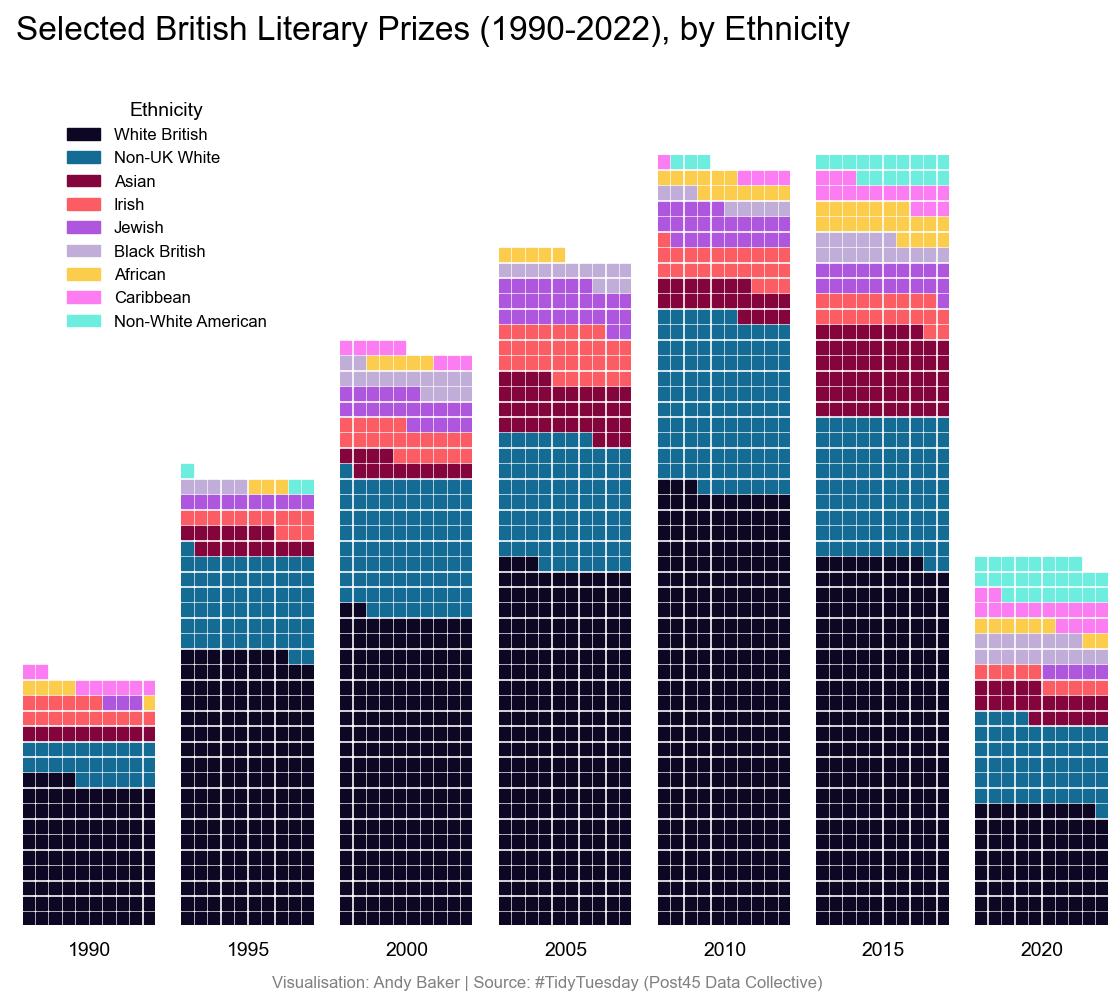

In [ ]:
# order for legend
categories = (
    prizes_agg.groupby("ethnicity_macro")["size"]
    .sum()
    .sort_values(ascending=False)
    .index.tolist()
)

# colour map
n_colors = len(categories)
palette = load_cmap("CrystalGems", keep_first_n=n_colors, shuffle=3).colors[:n_colors]
color_map = dict(zip(categories, palette))

# subplots
ncols = prizes_agg["prize_lustrum"].nunique()
fig, axs = plt.subplots(ncols=ncols, figsize=(14, 10))

# waffle plot
for year, ax in zip(prizes_agg["prize_lustrum"].unique(), axs):
    sub = prizes_agg[prizes_agg["prize_lustrum"] == year]

    sizes_in_order = [sub.loc[sub["ethnicity_macro"] == c, "size"].sum() for c in categories]

    remainder = max_year_value - sum(sizes_in_order)
    values = sizes_in_order + [remainder]

    colors_for_plot = [color_map[c] for c in categories] + ["white"]

    Waffle.make_waffle(
        ax=ax,
        rows=50,
        columns=10,
        values=values,
        vertical=True,
        colors=colors_for_plot,
    )

    ax.text(x=0.1, y=-0.04, s=f"{int(year)}", fontsize=14, ha="center")

title_text = (
    "Selected British Literary Prizes (1990-2022), by Ethnicity"
)
fig_text(
    x=0.12, y=1.02, s=title_text, ha="left", va="top", fontsize=24, font="Arial"
)

caption_text = "Visualisation: Andy Baker | Source: #TidyTuesday (Post45 Data Collective)"
fig_text(
    x=0.5, y=0.06, s=caption_text, ha="center", color="grey", fontsize=12, font="Arial"
)

# legend
handles = [mpatches.Patch(color=color_map[c], label=c) for c in categories]

fig.legend(
    handles=handles,
    loc="center right",
    bbox_to_anchor=(0.31, 0.82), # position
    frameon=False,
    ncol=1,
    prop={"family": "Arial", "size": 12},
    title_fontsize=14,
)

plt.rcParams["font.family"] = "Arial" # set global font
fig.tight_layout(rect=[0, 0, 0.95, 1])

fig.savefig(
    "2025_week43_britishliteraryprizes.png",
    dpi=300,
    bbox_inches="tight",
)
